In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import joblib
import pickle
from wordcloud import WordCloud

import nltk
from gensim import corpora, models, utils
from bs4 import BeautifulSoup

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, cdist, cosine


In [2]:
# Загрузим данные вакансий:

in_data = joblib.load("vacancies_list.pkl")
len(in_data)


5938

In [3]:
in_data[1]


{'id': '36497379',
 'premium': False,
 'billing_type': {'id': 'standard_plus', 'name': 'Стандарт плюс'},
 'relations': [],
 'name': 'Frontend-разработчик',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': {'from': 120000, 'to': None, 'currency': 'RUR', 'gross': False},
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': {'city': 'Москва',
  'street': 'улица Сущевский Вал',
  'building': '64',
  'description': None,
  'lat': 55.79179,
  'lng': 37.626385,
  'raw': 'Москва, улица Сущевский Вал, 64',
  'metro': {'station_name': 'Марьина Роща',
   'line_name': 'Люблинско-Дмитровская',
   'station_id': '10.185',
   'line_id': '10',
   'lat': 55.793723,
   'lng': 37.61618},
  'metro_stations': [{'station_name': 'Марьина Роща',
    'line_name': 'Люблинско-Дмитровская',
    'station_id': '10.185',
    'line_id': '10',
    'lat': 55.793723,
    'lng': 37.61618},
   {'station_name': 'Рижская

# 1. Выберем необходимые нам данные

## 1.1. Соберем ключевые навыки для каждой вакансии


In [4]:
all_vacancy = []
for vacancy in in_data:
    if 'key_skills' in vacancy:
        skill_bloc = vacancy['key_skills']
        one_skills = []
        for i in skill_bloc:
            one_skills.append(i['name'].lower())
        
        all_vacancy.append(one_skills)

len(all_vacancy)


5938

In [5]:
all_vacancy[20:40]


[['perl', 'ruby', 'python', 'elixir', 'influxdb', 'kafka', 'grafana', 'php'],
 ['sass', 'javascript', 'jquery', 'html5', 'css'],
 ['c#', 'javascript', 'asp.net', 'mysql'],
 ['sql',
  'ms sql',
  'qlik sense',
  'qlik view',
  'qlik nprinting',
  'qlik sense server',
  'nprinting server'],
 [],
 ['c#', 'dotnet', 'asp.net', 'mvc', '.net framework'],
 [],
 ['javascript',
  'node.js',
  'html5',
  'ориентация на результат',
  'умение работать в команде'],
 ['java', 'android api', 'android studio', 'gradle', 'git', 'php'],
 ['английский язык', 'ведение документации', 'unreal', 'c++'],
 ['javascript', 'html', '1с-битрикс', 'css', 'php5', 'ооп'],
 ['бэкенд',
  'erlang',
  'erlang-otp',
  'git',
  'postgresql',
  'redis',
  'ruby on rails'],
 ['postgresql',
  'git',
  'mysql',
  'javascript',
  'symfony',
  'php',
  'rest',
  'jquery',
  'html5',
  'css3',
  'memcached',
  'php5',
  'linux',
  'sql',
  'ооп',
  'json api',
  'docker',
  'sass'],
 ['wpf', 'wcf', 'c#', 'tfs', '.net framework'],


### Словарь предобработки

Для предобработки данных будем использовать словарь с опечатками и разными написаниями навыков.

Он был собран на основе наблюдений и анализа коррелирующих между собой навыков

Так же навыки, в написании которых используются различные символы, изменил на буквенные написания. Например, 'c++' заменил на 'cplus' и т.п.

In [6]:
erratum = {

    'f #': 'fsharp',
    '#f': 'fsharp',
    'f#': 'fsharp',
    'c #': 'csharp',
    'с#': 'csharp',
    'c#': 'csharp',
    'c ++': 'cplus',
    'с++': 'cplus',
    'c c++': 'cplus',
    'с c++': 'cplus',
    'с/c++': 'cplus',
    'c/c++': 'cplus',
    'c++': 'cplus',
    'r#': 'rsharp',
    'java,': 'java',
    'qa engineer': 'qa',
    'javascript': 'js',
    'spring framework': 'spring',
    'ооп': 'oop',
    'субд': 'sql',
    'знание js': 'js',
    ' js': 'js',
    '.js': 'js',
    ' го ': 'go',
    '1с': '1c',
    '.net framework': '.net',
    'postgresql': 'postgres', 
    'игры': 'games',
    'тестировщик': 'тестирование',
    'english': 'английский язык',
    'ms sql server': 'sql server',
    'data scient': 'data science',
    'data scientist': 'data science',
    'data scienceist': 'data science',
    'data science': 'ds',
    'machine learning': 'ml',
    'битрикс': 'bitrix',
    '1c bitrix': 'bitrix',
    'spark,': 'spark',
    'mongodb': 'mongo', 
    'scikit-learn': 'sklearn',
    'scikit learn': 'sklearn',
    'scikit': 'sklearn',
    'django framework': 'django',
    'анализ данных': 'data analysis',
    'elasticsearch': 'elastic',
    'unreal engine':'unreal',
    'yii':'ii',
    '.net csharp': 'net csharp',
    '.net core': 'net core',
    'nestjs': 'nest',
    'matlab simulink': 'simulink',
    'sql (percona)': 'percona',
    'ibm datastage': 'datastage',
    'raspberry pi': 'raspberry',
    'rabbitmq': 'rabbit',
    'scada': 'scad',
    'automation engineer': 'qa automation',
    'adobe indesign': 'indesign',
    'qlik': 'qli',
    'google data studio': 'data studio',
    'salesforce.com': 'force.com',
    'dpdk': 'pdk',
    'bigdata': 'big data',
    'ms sql': 'mssql',
    'transact-sql': 't-sql',
    'reverse engineering': 'reverse',
    'docker swarm': 'swarm', 
    'entity framework': 'entity',
    'unreal 4': 'unreal',
    '1c: предприятие 8': '1c предприятие',
    'dagger 2': 'dagger',
    'hdfs': 'hadoop',
    'rest api': 'rest',
    'restful api': 'restful',
    'тестирование по': 'тестирование', 
    'знание git': 'git',
}

In [7]:
# Фукнция очистки данных от знаков препинания, символов и исправления опечаток и различных написаний:

def cleaned_text(text):
    j = text.lower()
    
    for i in erratum:
        if i in j:
            while i in j:
                j = j.replace(i, erratum[i])
                
    rep = re.compile("[^a-zA-Zа-яА-я\d]")
    j = rep.sub(" ", j)
    return j


In [8]:
# Очистим нашей функцией ключевые навыки:

all_vacancy_cleaned = []

for i in all_vacancy:
    skills_l = []
    for j in i:
        j = cleaned_text(j)
        skills_l.append(j.strip())
    all_vacancy_cleaned.append(skills_l)
    
len(all_vacancy_cleaned)


5938

In [9]:
all_vacancy_cleaned[20:30]


[['perl', 'ruby', 'python', 'elixir', 'influxdb', 'kafka', 'grafana', 'php'],
 ['sass', 'js', 'jquery', 'html5', 'css'],
 ['csharp', 'js', 'asp net', 'mysql'],
 ['sql',
  'mssql',
  'qli sense',
  'qli view',
  'qli nprinting',
  'qli sense server',
  'nprinting server'],
 [],
 ['csharp', 'dotnet', 'asp net', 'mvc', 'net'],
 [],
 ['js',
  'nodejs',
  'html5',
  'ориентация на результат',
  'умение работать в команде'],
 ['java', 'android api', 'android studio', 'gradle', 'git', 'php'],
 ['английский язык', 'ведение документации', 'unreal', 'cplus']]

In [10]:
# Соберем все уникальные навыки:

unique_skills = []
for i in all_vacancy_cleaned:
    for j in i:
        if j not in unique_skills:
            unique_skills.append(j)
            
len(unique_skills)


2925

In [11]:
unique_skills[0:10]


['angularjs',
 'bootstrap',
 'базы данных',
 'mssql',
 'html5',
 'css3',
 'js',
 'ajax',
 'websocket',
 'csharp']

In [12]:
# Удалим различные слова, которые не являются навыками. Они были собраны в процессе анализа данных.

del_skills = ['front-end', 'frontend', 'frontend-разработчик', 'front end', 'frontend разработчик', 'фронтенд',
              'backend', 'back end', 'back-end', 'backend-разработчик', 'backend разработчик', 'frontend developer',
              'разработчик', 'аналитик', 'разработка', 'обучение', 'программист', 'data', 'радио', 'full-stack',
              'инженер', 'проектирование', 'интеграции', 'informatica', 'it', 'c', 'с', 'middle', 'full stack'
              'фитнес', 'дизайн', 'russian', 'тренинги', 'портал', 'корпоративные мероприятия', 'fullstack'
              'kiss', 'mes', 'renewals', 'гост', 'development', 'по', 'frameworks', 'pr', 'фитнес', 'мир',
              'менеджмент', 'консалтинг', 'teamlead', 'стажер', 'kiss', 'full stack', 'fullstack', 'skype'
             ]


for i in del_skills:
    if i in unique_skills:
        unique_skills.remove(i)
len(unique_skills)


2881

## 1.2. Соберем данные о предлагаемой зарплате

In [13]:
salary_for_frame = []

for vacancy in in_data:
    if 'salary' in vacancy:   
        vac = vacancy['salary']
        if vac:
            salary_for_frame.append((vac['from'], vac['to'], vac['currency'], vac['gross']))
        else:
            salary_for_frame.append((None, None, None, None))
len(salary_for_frame)


5938

In [14]:
salary_for_frame[20]


(90000, None, 'RUR', False)

In [15]:
salary_to = []
salary_from = []
salary_currency = []
salary_gross = []

for i in salary_for_frame:
    salary_from.append(i[0])
    salary_to.append(i[1])
    salary_currency.append(i[2])
    salary_gross.append(i[3])   
    

In [16]:
# Расчитаем среднюю разницу между предлагаемыми зарплатами "от" и "до":

l_from = []
l_to = []

EUR = 80
USD = 74

for vacancy in in_data:
    if 'salary' in vacancy:
        sal = vacancy['salary']
        
        if sal:
            if sal['from']:
                if sal['currency'] == 'EUR':
                    salaru_f = sal['from'] * EUR
                elif sal['currency'] == 'USD':
                    salaru_f = sal['from'] * USD
                elif sal['currency'] == 'RUR':
                    salaru_f = sal['from']
                l_from.append(salaru_f)
            
            if sal['to']:
                if sal['currency'] == 'EUR':
                    salaru_t = sal['to'] * EUR
                elif sal['currency'] == 'USD':
                    salaru_t = sal['to'] * USD
                elif sal['currency'] == 'RUR':
                    salaru_t = sal['to']
                
                l_to.append(salaru_t)

print(len(l_from), len(l_to))


1348 966


In [17]:
coef_from = np.median(l_to) / np.median(l_from)
coef_to = np.median(l_from) / np.median(l_to)

print(np.median(l_from), np.median(l_to), coef_from, coef_to)


120000.0 150000.0 1.25 0.8


Разница в предлагаемой зарплате "от" и "до" составляет 1,25 раза, и 0,8 - наоборот


Создадим размер предлагаемой зарплаты, которую и будем использовать в дальнейших расчетах.

1. Все вакансии в валюте переведем в рубли
2. Если в вакансии указаны зарплаты "от" и "до", то возьмем среднее
3. Если в вакансии указана зарплата только "от", то умножим ее на 1,25
4. Если в вакансии указана зарплата только "до", то умножим ее на 0,8


In [18]:

EUR = 80
USD = 74

list_salary = []

for vacancy in in_data:
    if 'salary' in vacancy: 
        sal = vacancy['salary']
        
        if sal:
            if sal['from'] and sal['to']: salaru_vac = (sal['from'] + sal['to']) / 2 
            elif sal['from']: salaru_vac = sal['from'] * coef_from
            elif sal['to']: salaru_vac = sal['to'] * coef_to
            else: salaru_vac = 0

            if sal['currency'] == 'EUR': salaru_itog = salaru_vac * EUR
            elif sal['currency'] == 'USD': salaru_itog = salaru_vac * USD
            elif sal['currency'] == 'RUR': salaru_itog = salaru_vac
                
        else:
            salaru_itog = 0
        
        list_salary.append(int(salaru_itog))
        
len(list_salary)


5938

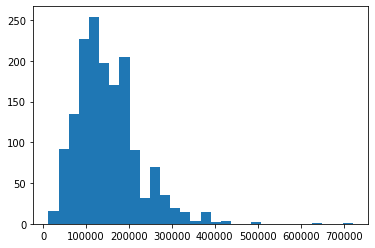

In [74]:
# Посмотрим на распределение зарплат:

salary_hist = [i for i in list_salary if i > 0]
plt.hist(salary_hist, bins = 30);


## 1.3. Соберем тип занятости


In [20]:
vacancy_employment = []

for vacancy in in_data:
    if 'employment' in vacancy:
        vacancy_employment.append(vacancy['employment']['id'])

len(vacancy_employment)


5938

In [21]:
np.unique(vacancy_employment)


array(['full', 'part', 'probation', 'project'], dtype='<U9')

## 1.4. Соберем все описания вакансий

In [22]:
vacancy_descriptions = []

for vacancy in in_data:
    if 'description' in vacancy:
        text_vacancy = vacancy['description'].lower()
        
        vacancy_descriptions.append(text_vacancy)

len(vacancy_descriptions)


5938

In [23]:
vacancy_descriptions[20]


'<p>наша компания уже много лет работает над сложными проектами, в том числе крупными b2b, которые состоят из десятков сервисов на ruby/rails, erlang, elixir, jruby, java.</p> <p>мы сами создаем и поддерживаем проекты, поэтому для нас важно контролировать корректность их работы. вам предлагается присоединиться к нашей команде и заняться разработкой инструментов, позволяющих мониторить сервисы, собирать и анализировать их логи и, в конечном итоге, улучшать их работу.</p> <p> </p> <p><strong>наш стек:</strong></p> <ul> <li>логи и apache flume, kafka, hdfs, pig, spark, elasticsearch, kibana, filebeat.</li> <li>метрики и influxdb, kapacitor, telegraf, grafana.</li> </ul> <p> </p> <p><strong>что нужно уметь:</strong></p> <ul> <li>понимать, что такое метрики сервисов, и иметь интерес к этой теме.</li> <li>иметь опыт бэкенд разработки на любом из мейнстримовых скриптовых языков: python/perl/node.js/ruby/php/...</li> <li>хорошо знать linux как со стороны разработчика, так и со стороны пользова

In [24]:
%%time

# Удалим все html-тэги

vacancy_descriptions = [BeautifulSoup(doc, "html.parser").text.lower() for doc in vacancy_descriptions]
len(vacancy_descriptions)


CPU times: user 12.5 s, sys: 126 ms, total: 12.6 s
Wall time: 12.8 s


5938

In [25]:
vacancy_descriptions[20]


'наша компания уже много лет работает над сложными проектами, в том числе крупными b2b, которые состоят из десятков сервисов на ruby/rails, erlang, elixir, jruby, java. мы сами создаем и поддерживаем проекты, поэтому для нас важно контролировать корректность их работы. вам предлагается присоединиться к нашей команде и заняться разработкой инструментов, позволяющих мониторить сервисы, собирать и анализировать их логи и, в конечном итоге, улучшать их работу.   наш стек:  логи и apache flume, kafka, hdfs, pig, spark, elasticsearch, kibana, filebeat. метрики и influxdb, kapacitor, telegraf, grafana.    что нужно уметь:  понимать, что такое метрики сервисов, и иметь интерес к этой теме. иметь опыт бэкенд разработки на любом из мейнстримовых скриптовых языков: python/perl/node.js/ruby/php/... хорошо знать linux как со стороны разработчика, так и со стороны пользователя.  если вы не вполне уверены в соответствии требованиям, но упомянутые технологии вам интересны, вы хотите ими заниматься и м

In [26]:
# Очистим описания вакансий и вставим в начало и конец пробелы, 
# это будет необходимо в дальнейшем при составлении векторов навыков

vacancy_descriptions_cleaned = []
for i in vacancy_descriptions:
    vacancy_descriptions_cleaned.append(' ' + cleaned_text(i) + ' ')

len(vacancy_descriptions_cleaned)


5938

In [27]:
vacancy_descriptions_cleaned[20]


' наша компания уже много лет работает над сложными проектами  в том числе крупными b2b  которые состоят из десятков сервисов на ruby rails  erlang  elixir  jruby  java  мы сами создаем и поддерживаем проекты  поэтому для нас важно контролировать корректность их работы  вам предлагается присоединиться к нашей команде и заняться разработкой инструментов  позволяющих мониторить сервисы  собирать и анализировать их логи и  в конечном итоге  улучшать их работу    наш стек   логи и apache flume  kafka  hadoop  pig  spark elastic  kibana  filebeat  метрики и influxdb  kapacitor  telegraf  grafana     что нужно уметь   понимать  что такое метрики сервисов  и иметь интерес к этой теме  иметь опыт бэкенд разработки на любом из мейнстримовых скриптовых языков  python perl nodejs ruby php     хорошо знать linux как со стороны разработчика  так и со стороны пользователя   если вы не вполне уверены в соответствии требованиям  но упомянутые технологии вам интересны  вы хотите ими заниматься и можете

## 1.5. Соберем названия вакансий


In [28]:
vacancy_name = []

for vacancy in in_data:
    if 'name' in vacancy:
        text_vacancy = vacancy['name'].lower()        
        vacancy_name.append(text_vacancy)

len(vacancy_name)


5938

In [29]:
vacancy_name[3]


'full-stack разработчик .net/c#'

In [30]:
# Обработаем названия и так же добавим в начало и конец пробелы

vacancy_name_cleaned = []
for i in vacancy_name:
    vacancy_name_cleaned.append(' ' + cleaned_text(i) + ' ')

len(vacancy_name_cleaned)


5938

In [31]:
vacancy_name_cleaned[3]


' full stack разработчик  net csharp '

## 1.6. Соберем все ссылки на вакансии


In [32]:
alternate_url = []
for vacancy in in_data:
    if 'alternate_url' in vacancy:
        alternate_url.append(vacancy['alternate_url'])

len(alternate_url)


5938

## 1.7. Соберем требуемый опыт

Обозначение требуемого опыта:
    - noExperience - без опыта - junior
    - between1And3 - от 1 года до 3 - middle
    - between3And6 - от 3 до 6 лет - senior
    - moreThan6 - более 6 лет - senior
    

In [33]:
experiences = []
for i in in_data:
    if 'experience' in i:
        if i['experience']['id'] == 'noExperience':
            experiences.append('junior')
        elif i['experience']['id'] == 'between1And3':
            experiences.append('middle')
        else:
            experiences.append('senior')

len(experiences)


5938

In [34]:
np.unique(experiences)


array(['junior', 'middle', 'senior'], dtype='<U6')

# 2. Сформируем профиль навыков каждой вакансии

Мы проходим по общему списку наших ключевых навыком и, если оно встречается в описании, названии или навыках, добавляем в профиль.

Чтобы не вычленять навыки из обычных слов (например, навык 'oop' можно найти в слове 'hadoop'), мы будем использовать при поиске ключевого слова только при наличии пробелов "вокруг" слова.
Как раз для этого нам пригодятся пробелы в начале и конце описаний и названий, т.к. ключевой навых может стоять в начале или конце описания.



In [35]:
%%time

one_vacancy_t = [] # вектор наличия/отсутствия навыка
one_vac_skills = [] # список навыков вакансий

for s in range(len(all_vacancy_cleaned)):
    i = all_vacancy_cleaned[s]
    j = vacancy_descriptions_cleaned[s]
    g = vacancy_name_cleaned[s]
    
    
    one_vacancy = []
    one_vac_s = []
    for k in unique_skills:
        kk = ' ' + k + ' '
        if (kk in i) or (kk in j) or (kk in g):
            one_vacancy.append(1)
            one_vac_s.append(k)
        else:
            one_vacancy.append(0)
    one_vacancy_t.append(one_vacancy)
    one_vac_skills.append(one_vac_s)

print(len(one_vacancy_t), len(one_vac_skills))


5938 5938
CPU times: user 35.3 s, sys: 429 ms, total: 35.7 s
Wall time: 36.4 s


In [36]:
# Переведем списки навыков каждой вакансии в строки:

one_vac_skills_fr = list()
for i in one_vac_skills:
    st = ''
    for j in i:
        st = st + j + ' '
    one_vac_skills_fr.append(st)

len(one_vac_skills_fr)


5938

In [37]:
# Создадим DataFrame с данными вакансий:

dic_for_frame = {
    'name': vacancy_name_cleaned,
    'skills': one_vac_skills_fr,
    'describe': vacancy_descriptions_cleaned,
    'url': alternate_url,
    'salary_from': salary_from,
    'salary_to': salary_to,
    'salary_currency': salary_currency,
    'salary_gross': salary_gross,
    'salary_median': list_salary,
    'experience': experiences,
    'employment': vacancy_employment,
}

data_vacances = pd.DataFrame(dic_for_frame)
data_vacances.head()


,name,skills,describe,url,salary_from,salary_to,salary_currency,salary_gross,salary_median,experience,employment
0,программист разработчик,angularjs bootstrap mssql spring redmine maven...,обязанности у нас есть работающий проект...,https://hh.ru/vacancy/36540961,200000.0,NaN,RUR,False,250000,middle,project
1,frontend разработчик,bootstrap html5 css3 js ajax websocket git vue...,компания эргосоло работает с 2002 года наш...,https://hh.ru/vacancy/36497379,120000.0,NaN,RUR,False,150000,middle,full
2,ведущий frontend разработчик,bootstrap js react angular vuejs oop css es6 s...,verme уже более 6 лет является экспертом wfm ...,https://hh.ru/vacancy/35493020,150000.0,NaN,RUR,False,187500,senior,full
3,full stack разработчик net csharp,mssql csharp net wpf рефакторинг умение работа...,региональное представительство компании quipu...,https://hh.ru/vacancy/36741295,1800.0,NaN,EUR,False,180000,middle,full
4,frontend разработчик,react webpack redux typescript api ux saga sty...,расширяем команду и ищемjs разработчика с ш...,https://hh.ru/vacancy/36676120,220000.0,260000.0,RUR,False,240000,senior,full


# 3. Краткий обзор собранных данных

## 3.1. Посмотрим на требуемый опыт

In [38]:
data_vacances['experience'].value_counts()


middle    2735
senior    2653
junior     550
Name: experience, dtype: int64

## 3.2. Тип занятости

In [39]:
data_vacances['employment'].value_counts()


full         5771
part           75
project        57
probation      35
Name: employment, dtype: int64

## 3.3. Посмотрим на зарплаты 

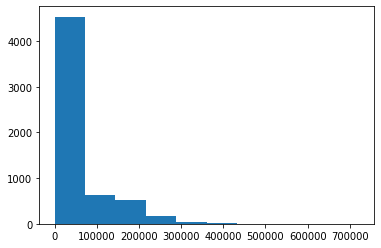

In [40]:
plt.hist(data_vacances['salary_median']);


In [41]:
# Отберем вакансии с зарплатой более 10000 и с полной занятостью.
df = data_vacances[data_vacances['salary_median'] > 10000]
df = df[df['employment'] == 'full']
df


,name,skills,describe,url,salary_from,salary_to,salary_currency,salary_gross,salary_median,experience,employment
1,frontend разработчик,bootstrap html5 css3 js ajax websocket git vue...,компания эргосоло работает с 2002 года наш...,https://hh.ru/vacancy/36497379,120000.0,NaN,RUR,False,150000,middle,full
2,ведущий frontend разработчик,bootstrap js react angular vuejs oop css es6 s...,verme уже более 6 лет является экспертом wfm ...,https://hh.ru/vacancy/35493020,150000.0,NaN,RUR,False,187500,senior,full
3,full stack разработчик net csharp,mssql csharp net wpf рефакторинг умение работа...,региональное представительство компании quipu...,https://hh.ru/vacancy/36741295,1800.0,NaN,EUR,False,180000,middle,full
4,frontend разработчик,react webpack redux typescript api ux saga sty...,расширяем команду и ищемjs разработчика с ш...,https://hh.ru/vacancy/36676120,220000.0,260000.0,RUR,False,240000,senior,full
5,frontend разработчик,angularjs react less git sass angular scss spa...,приглашаем front end разработчика с опытом от...,https://hh.ru/vacancy/36669665,NaN,60000.0,RUR,True,48000,middle,full
...,...,...,...,...,...,...,...,...,...,...,...
5925,java developer voip,cplus agile rest java docker golang kubernetes...,наш клиент американская компания ooma разра...,https://hh.ru/vacancy/34313448,NaN,300000.0,RUR,False,240000,senior,full
5926,программист bitrix bitrix24,less oop php jquery css sql html 1c bitrix jso...,задачи разработка и поддержка веб сайтов на...,https://hh.ru/vacancy/36718950,60000.0,110000.0,RUR,False,85000,senior,full
5928,разработчик на java senior москва,базы данных react nodejs gulp webpack java pos...,привет я саша cto в driverpack у нас неболь...,https://hh.ru/vacancy/36532390,NaN,300000.0,RUR,False,240000,senior,full
5930,back end разработчик java sql,mssql git sql java oracle spring oracle pl sql...,it компания с многолетней экспертизой в разра...,https://hh.ru/vacancy/33443666,NaN,180000.0,RUR,False,144000,middle,full


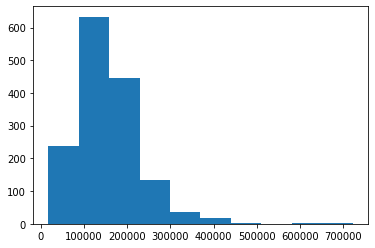

In [42]:
plt.hist(df['salary_median']);


In [43]:
# Посмотрим на минимальную и максимальную предлагаемую зарплату:

print(df['salary_median'].min(), df['salary_median'].max())


17500 721500


In [44]:
# Посмотрим на среднюю зарплату у каждого уровня опыта:

print(int(df[df['experience'] == 'junior']['salary_median'].median()))
print(int(df[df['experience'] == 'middle']['salary_median'].median()))
print(int(df[df['experience'] == 'senior']['salary_median'].median()))


100000
125000
175000


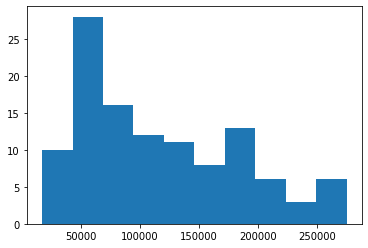

In [45]:
# Посмотрим на распределение зарплат у junior:

xcz = df[(df['experience'] == 'junior')]
plt.hist(xcz['salary_median']);


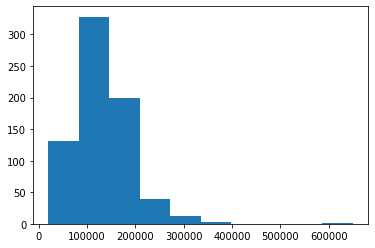

In [46]:
# Посмотрим на распределение зарплат у middle:

xcz = df[(df['experience'] == 'middle')]
plt.hist(xcz['salary_median']);


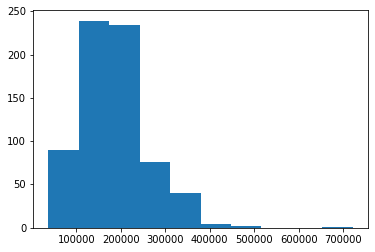

In [47]:
# Посмотрим на распределение зарплат у senior:

xcz = df[df['experience'] == 'senior']
plt.hist(xcz['salary_median']);


In [68]:
# Посмотрим сколько вакансий с предлагаемой зарплатой ниже 40 000 р.:

df[(df['salary_median'] < 40000)].shape[0]


16

In [69]:
# Посмотрим на пропуски в наших данных:

pd.isnull(df).sum()


index                0
name                 0
skills               0
describe             0
url                  0
salary_from        221
salary_to          595
salary_currency      0
salary_gross         3
salary_median        0
experience           0
employment           0
dtype: int64

# 4. Переведем вакансии в вектора навыков

In [50]:
%%time

df.reset_index(inplace = True)

one_vacancy_vec = [] # вектор наличия/отсутствия навыка
one_vacancy_skills = [] # список вакансий

for s in range(len(df)):
    i = df['skills'][s]
    j = df['describe'][s]
    g = df['name'][s]
    
    one_vacancy = []
    one_vac_s = []
    for k in unique_skills:
        kk = ' ' + k + ' '
        if (kk in i) or (kk in j) or (kk in g):
            one_vacancy.append(1)
            one_vac_s.append(k)
        else:
            one_vacancy.append(0)
    one_vacancy_vec.append(one_vacancy)
    one_vacancy_skills.append(one_vac_s)

print(len(one_vacancy_vec), len(one_vacancy_skills))


1513 1513
CPU times: user 8.71 s, sys: 118 ms, total: 8.83 s
Wall time: 8.9 s


In [51]:
%%time

# Создадим DataFrame векторов вакансий:

vacances_in_skills = pd.DataFrame(one_vacancy_vec, columns = unique_skills)
vacances_in_skills


CPU times: user 1.5 s, sys: 84.2 ms, total: 1.58 s
Wall time: 1.57 s


,angularjs,bootstrap,базы данных,mssql,html5,css3,js,ajax,websocket,csharp,...,радиоэлектроника,lean,nwjs,electron,реф приложения,ie6,работа с большим пулом запросов,1c ерп,sprig boot,pistgresql
0,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1510,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1511,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Удалим слишком частые и слишком редкие признаки

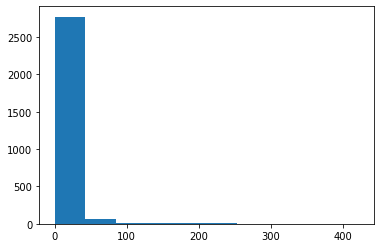

In [52]:
plt.hist(vacances_in_skills.sum(), bins = 10);


In [53]:
del_columns_small = []
for i in vacances_in_skills:
    if vacances_in_skills[i].sum() < 15:
        del_columns_small.append(i)

len(del_columns_small)


2601

In [54]:
del_columns_many = []
for i in vacances_in_skills:
    if vacances_in_skills[i].sum() > 500:
        del_columns_many.append(i)

len(del_columns_many)


0

In [55]:
del_columns_many

[]

In [56]:
del_columns = del_columns_many + del_columns_small
vacances_in_skills_opt = vacances_in_skills.drop(del_columns, axis = 1)
vacances_in_skills_opt


,angularjs,bootstrap,базы данных,mssql,html5,css3,js,ajax,websocket,csharp,...,отчеты,анализ требований,html css,github,communication skills,код ревью,dry,microsoft,mobile,внимательность
0,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1510,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1511,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


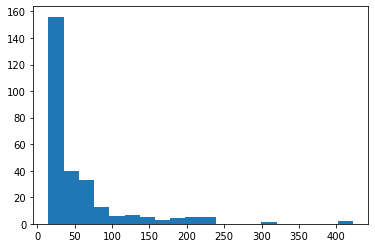

In [57]:
plt.hist(vacances_in_skills_opt.sum(), bins = 20);


### Удалим элементы с малым и большим количеством данных

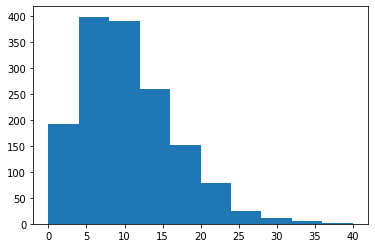

In [58]:
plt.hist(vacances_in_skills_opt.sum(axis = 1));


In [59]:
index_label_del = vacances_in_skills_opt[(vacances_in_skills_opt.sum(axis = 1) < 5)].index.tolist()
index_label_del_2 = vacances_in_skills_opt[(vacances_in_skills_opt.sum(axis = 1) > 40)].index.tolist()

index_del = index_label_del + index_label_del_2

len(index_del)


284

In [60]:
data = vacances_in_skills_opt.drop(index = index_del)
data


,angularjs,bootstrap,базы данных,mssql,html5,css3,js,ajax,websocket,csharp,...,отчеты,анализ требований,html css,github,communication skills,код ревью,dry,microsoft,mobile,внимательность
0,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1510,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Сохраним получившиеся данные в файлы:

data.to_csv('vectors_data.csv')
df.iloc[data.index.tolist()].to_csv('data_vacances.csv')


### Посмотрим на коррелирующие данные

С помощью корреляции было найдено много навыков с опечатками и разным написанием, что вылилось в большой словарь "erratum", который использовался для предобработки данных.

In [70]:
Corr = data.corr()

CorField = []
CorPairs = []
CorrDel = []

for i in Corr:
    for j in Corr.index[Corr[i] > 0.80]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            CorPairs.append([i, j, Corr[i][Corr.index == j].values[0]])
            CorrDel.append(j)
            print (i, '-->', j, ': R =', Corr[i][Corr.index == j].values[0])


html5 --> css3 : R = 0.8215390485080104
sql server --> server : R = 0.8266089802405546
pl sql --> pl : R = 0.9269330876716637
яндекс метрика --> google analytics : R = 0.8870583142956777
